In [25]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [26]:
EPOCHS = 30
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

<h3>Preprocessing the data</h3>

In [27]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(224),  
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  
        ])
        
    if phase == VAL:

        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:0


<h3>Load the data</h3>

In [28]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}


dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True), 
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)
}

In [29]:
print(len(dataloaders[TRAIN]))
print(len(dataloaders[TEST]))
print(len(dataloaders[VAL]))

1304
624
16


In [30]:
dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in [TRAIN, VAL]
}


classes = image_datasets[TRAIN].classes

class_names = image_datasets[TRAIN].classes

<h3>Visualize the data</h3>

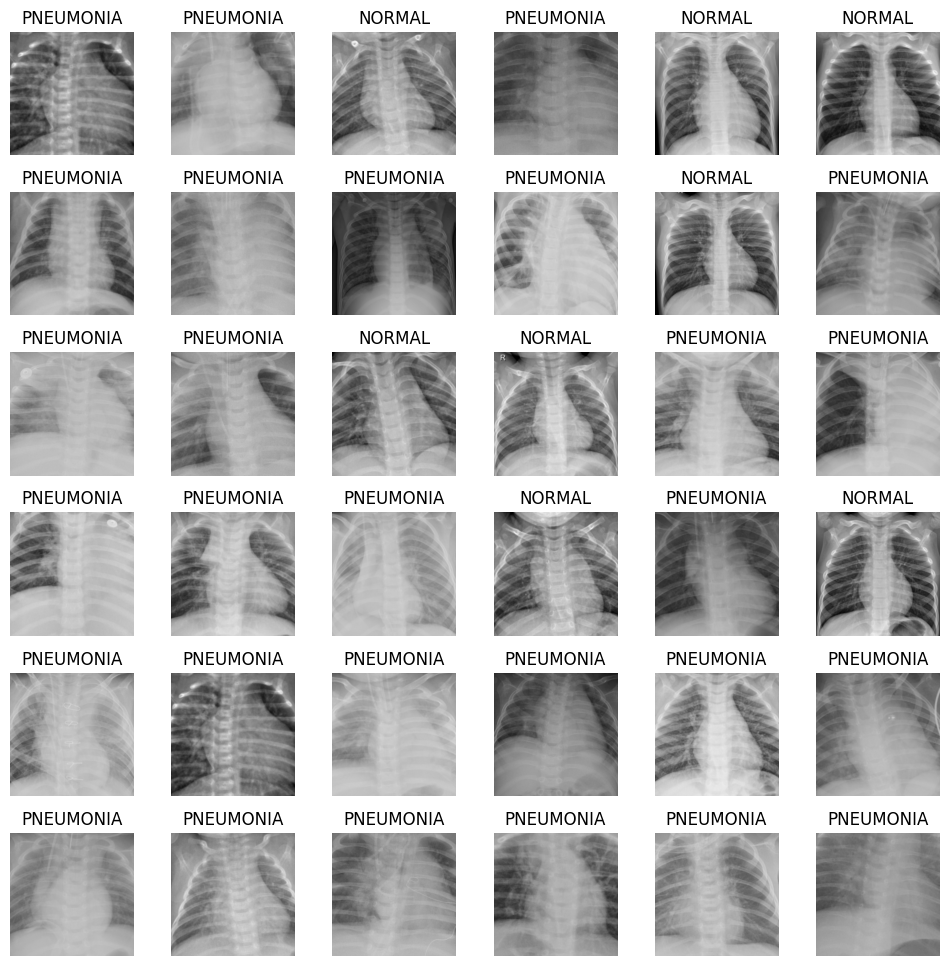

In [31]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [32]:
inputs, classes = next(iter(dataloaders[TRAIN]))

<h3>Define model</h3>

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model if we have a new best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)
    return model

In [34]:
def rename_keys(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("norm.1", "norm1").replace("norm.2", "norm2").replace("conv.1", "conv1").replace("conv.2", "conv2")
        new_state_dict[new_key] = value
    return new_state_dict


In [35]:
import torch
import torch.nn as nn
from torchvision import models

# Đường dẫn tới tệp mô hình đã tải lên
model_path = '/kaggle/input/chexnet/pytorch/chest_xray_chexnet/1/densenet121-a639ec97.pth'

# Load state_dict từ tệp cục bộ
state_dict = torch.load(model_path)

# Chuyển đổi khóa trong state_dict
state_dict = rename_keys(state_dict)

# Load pre-trained DenseNet-121 từ tệp cục bộ
model_pre = models.densenet121()
model_pre.load_state_dict(state_dict)

# # Modify the classifier to match the number of classes in your dataset
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, len(class_names))

# # Move the model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


<All keys matched successfully>

In [36]:
for param in model_pre.features.parameters():
    param.required_grad = False

# Sửa đổi lớp classifier để phù hợp với số lượng lớp trong dataset
num_features = model_pre.classifier.in_features
model_pre.classifier = nn.Linear(num_features, len(class_names))

# Di chuyển mô hình tới GPU nếu có
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_pre = model_pre.to(device)

print(model_pre)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [37]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [38]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30
train Loss: 0.1850 Acc: 0.9277
val Loss: 0.5216 Acc: 0.6875
Epoch: 2/30
train Loss: 0.1016 Acc: 0.9697
val Loss: 0.2749 Acc: 0.8750
Epoch: 3/30
train Loss: 0.0770 Acc: 0.9760
val Loss: 0.1421 Acc: 0.9375
Epoch: 4/30
train Loss: 0.0712 Acc: 0.9808
val Loss: 0.5207 Acc: 0.6875
Epoch: 5/30
train Loss: 0.0700 Acc: 0.9804
val Loss: 0.3868 Acc: 0.8125
Epoch: 6/30
train Loss: 0.0551 Acc: 0.9814
val Loss: 0.2994 Acc: 0.8125
Epoch: 7/30
train Loss: 0.0672 Acc: 0.9806
val Loss: 0.7315 Acc: 0.6875
Epoch: 8/30
train Loss: 0.0613 Acc: 0.9808
val Loss: 0.7992 Acc: 0.6250
Epoch: 9/30
train Loss: 0.0528 Acc: 0.9826
val Loss: 0.1977 Acc: 0.9375
Epoch: 10/30
train Loss: 0.0369 Acc: 0.9893
val Loss: 0.3820 Acc: 0.8125
Epoch: 11/30
train Loss: 0.0198 Acc: 0.9964
val Loss: 0.2077 Acc: 0.9375
Epoch: 12/30
train Loss: 0.0243 Acc: 0.9921
val Loss: 0.1630 Acc: 0.9375
Epoch: 13/30
train Loss: 0.0092 Acc: 0.9996
val Loss: 0.2151 Acc: 0.9375
Epoch: 14/30
train Loss: 0.0139 Acc: 0.9962
val Loss: 0.2432

In [40]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Store true labels
            true_labels.append(labels.item())
            
            #Store model input images
            input_images.append(inputs)
            
            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

In [41]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

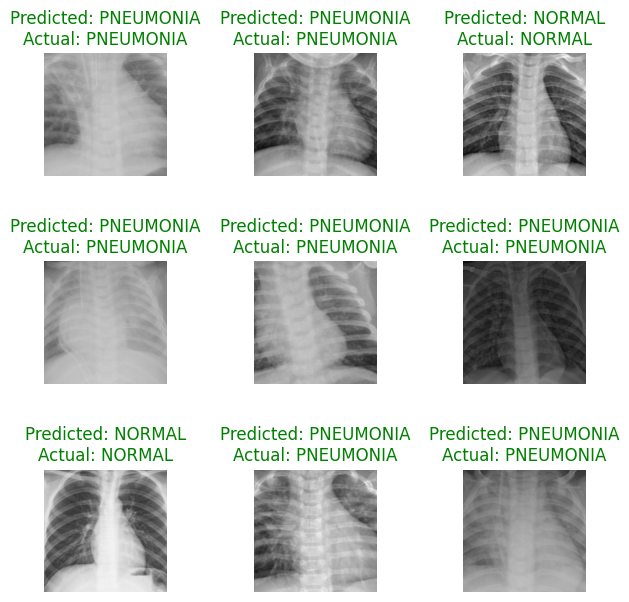

In [43]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()
      
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        
        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()


In [44]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 551.0 
Total Test Images: 624.0
Test Accuracy:  0.8830128205128205
